In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl):   ###resetmcl2
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold  #閾値(self.alphasから書き換える）
        
    def random_reset(self): #追加
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
        
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()   #以下書き換え

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: #αの計算
            self.random_reset()
        else:
            self.resampling() 

<IPython.core.display.Javascript object>


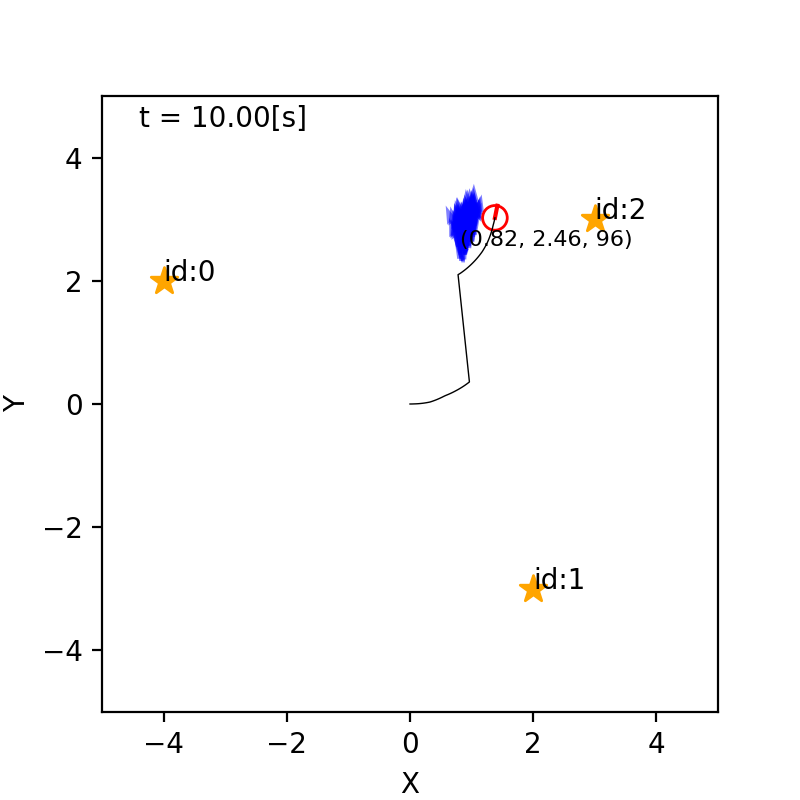

(array([0, 0, 0]), array([0, 0, 0]))

In [3]:
def trial(animation):    ###resetmcl2trial
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(-4,2), (2,-3), (3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)   

    ### ロボットを作る ###
    initial_pose = np.array([0, 0, 0]).T
    pf = ResetMcl(m, initial_pose, 100)
    circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
#  r = Robot(initial_pose, sensor=Camera(m), agent=circling, color="red")   #誘拐なし（コメントアウト）
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=circling, expected_kidnap_time=10.0, color="red") #誘拐あり
    world.append(r)

    world.draw()
    
    return (r.pose, pf.pose) 
    
trial(True)

In [4]:
def trial(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimatorAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

In [5]:
def evaluation(): #'__main__': ###mclglobal1exec
    ok = 0
    for i in range(1000):
        actual, estm = trial(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:", actual, "推定値", estm, "誤差:", diff)
        if diff <= 1.0:
            ok += 1

    ok